In [312]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# ^^^ pyforest auto-imports - don't write above this line
import pyforest

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as pt
import seaborn

import time 

#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

import warnings
import os

warnings.filterwarnings("ignore")

# Préparation de données :

In [127]:
path_csv = "D:\\etude_data_science\\Kaggle_competition\\03_Multi-Class Prediction of Obesity Risk\\dataset\\"

In [128]:
data_cleaned = pd.read_csv(path_csv+"final_df.csv")
df = data_cleaned.copy()

In [129]:
#Gardons l'id des lignes pour plus tard
identifiant = df["id"]

In [130]:
X,y = df.drop(columns=["id", "NObeyesdad"], axis = 1), df["NObeyesdad"]

In [131]:
X_train, X_test,y_train,y_test = train_test_split(X,y, random_state=42)

#### Encodage de la target

In [114]:
encoder = LabelEncoder()
encoder.fit(y_train)

<IPython.core.display.Javascript object>

LabelEncoder()

In [116]:
y_train, y_test = encoder.transform(y_train), encoder.transform(y_test)

In [132]:
print("Dimensions après split des données :\n")
print(f"X train :{X_train.shape}")
print(f"y train :{y_train.shape}")
print()
print(f"X test :{X_test.shape}")
print(f"y test :{y_test.shape}")

Dimensions après split des données :

X train :(15568, 20)
y train :(15568,)

X test :(5190, 20)
y test :(5190,)


# Plan : 

#### 1. Création des fonctions de modélisation 

#### 2. Entrainement et enregistrement des modèles

#### 3. Résultats et premières selection de modèles

#### 4. Visualisation des autres metrics

#### 5. Amélioration des modèles par GridSearchCV

#### 6. Visualisation des performances

#  1. Création des fonctions de modélisation

In [297]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    OneVsRestClassifier(model.fit(X_train,y_train))
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(type(model).__name__)
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen", scores.mean().round(3))

    return (yp, training_time_min, model)

In [298]:
def metric(prediction, model_name, exe_time):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score et le temps d'execution
    à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction, average='weighted')
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction, average='weighted')
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction, average='weighted')
    
    all_metric = [f1,accuracy,recal,precision, exe_time]
    
    index_metric = ["F1","accuracy","recall","precision","duree_entrainement(min)"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)
    

In [391]:
def matrice(prediction):
    cf = metrics.confusion_matrix(y_true=y_test, y_pred=prediction)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(cf, annot = True, linewidths=0.8, linecolor="black", fmt = ".0f",cbar=False, cmap = "Blues")
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Valeurs réelles')
    plt.title("Confusion Matrix")
    plt.show()

In [373]:
def ROC(model):
    """Fonction pour obtenir la courbe ROC pour la classification multiclasse"""
    n_classes = len(np.unique(y_test))
    # Binarisez les étiquettes (labels) pour pouvoir les utiliser dans roc_curve
    y_test_binarized = label_binarize(y_test, classes=model.classes_)
    predicted_probabilities = model.predict_proba(X_test.values)

    # Initialisez la figure pour le tracé
    plt.figure(figsize=(10, 8))

    # Calculez la courbe ROC pour chaque classe
    for i in range(len(model.classes_)):
        fpr, tpr, _ = metrics.roc_curve(y_test_binarized[:, i], predicted_probabilities[:, i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {model.classes_[i]} (AUC = {roc_auc:.2f})')

    # Tracer la ligne en pointillés représentant la performance aléatoire
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')

    # Ajoutez des légendes, un titre et des étiquettes d'axe
    plt.legend(loc="lower right")
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC pour un problème de classification multiclasse')
    plt.grid(True)
    plt.show()

## 2. Entrainement des différents modèles et récupération des metrics :
- Nous allons créer une boucle qui va parcourir notre liste des modèles utilisés et qui fera :
    - Entrainement des modèles et récupèrera les prédictions et les temps d'execution
    - Enregistrement du modèle sur le dictionnaire dict_model_trained
    - Ajout des metrics dans le dictionnaire dict_metric
    - ajout des prédiction dans le dictionnaire dict_prediction
    -  enregistrement final dans un dataframe contenant les différentes metrics

In [300]:
all_model = [DummyClassifier(strategy="most_frequent"),LogisticRegression(),
             KNeighborsClassifier(),SGDClassifier(loss="modified_huber"),RandomForestClassifier()]

#Remarque : Nous mettons loss = "modified_huber" pour SGDC,cela permet d'utiliser le "predict_proba(X_test.values)"
# Ceci est utilisé lors de la création de la fonction ROC où nous devons utiliser predict_proba ainsi que label_binarizer
#sinon cela ne fonctionne pas du fait que la courbe ROC est initialement prévu pour des problemes binaires


In [301]:
#Dictionnaire qui contiendra les différentes metrics de chaque modèle
dict_metric = {}

#dictionnaire contenant les valeurs prédictives pour chaque modèles
dict_prediction = {}

#dictionnaire contenant les modele entrainé
dict_model_trained = {}

for current_model in all_model:
    #Recuperation des prédictions et du temps d'execution de chaque modèles
    prediction, temps_exe, model_trained = train(current_model)
    
    
    # Récupération du nom du modèle et du chemin d'enregistrement
    model_name = type(current_model).__name__
    
    # Enregitrement des modèles après entrainement : 
    dict_model_trained[model_name] = model_trained
    
    #Enregistrement des prédiction dans le dictionnaire :
    dict_prediction[model_name] = prediction
    
    # Enregistrement des métriques au dictionnaire
    dict_metric[model_name] = metric(prediction=prediction, model_name=model_name, exe_time=temps_exe)

DummyClassifier
Scores sur 5 splits :  [0.195, 0.195, 0.195, 0.195, 0.194]
Score moyen 0.195
LogisticRegression
Scores sur 5 splits :  [0.846, 0.862, 0.838, 0.85, 0.862]
Score moyen 0.851
KNeighborsClassifier
Scores sur 5 splits :  [0.776, 0.775, 0.779, 0.779, 0.778]
Score moyen 0.777
SGDClassifier
Scores sur 5 splits :  [0.669, 0.69, 0.713, 0.692, 0.678]
Score moyen 0.688
RandomForestClassifier
Scores sur 5 splits :  [0.881, 0.891, 0.886, 0.894, 0.901]
Score moyen 0.891


In [302]:
path_trained_model = r"D:\Etude_Data_science\Kaggle_competition\03_Multi-Class Prediction of Obesity Risk\modeles\\"

In [303]:
#Pour les Dataframe :    
# Concaténation des métriques en un DataFrame
df_metrics = pd.concat(dict_metric.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics = df_metrics.T
df_metrics

,F1,accuracy,recall,precision,duree_entrainement(min)
DummyClassifier,0.064213,0.195954,0.195954,0.038398,0.00
LogisticRegression,0.856399,0.857611,0.857611,0.855860,0.01
KNeighborsClassifier,0.768898,0.772062,0.772062,0.768526,0.00
SGDClassifier,0.702259,0.720424,0.720424,0.709130,0.01
RandomForestClassifier,0.890049,0.890173,0.890173,0.890339,0.04


In [304]:
# Enregistrement du DataFrame des métriques
df_metrics.to_csv("df_metrics.csv")

#Enregistrement des prédictions dans un dataframe :
df_prediction = pd.DataFrame(dict_prediction)
# Enregistrement du DataFrame des prédictions
df_prediction.to_csv("df_prediction.csv")


In [305]:
#Enregistrement des modèles :

for i in dict_model_trained:
    model_name = i
    current_model = dict_model_trained[model_name]
    model_filename = os.path.join(path_trained_model, f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


In [306]:
df_metrics.sort_values(by = "F1", ascending=False)

,F1,accuracy,recall,precision,duree_entrainement(min)
RandomForestClassifier,0.890049,0.890173,0.890173,0.890339,0.04
LogisticRegression,0.856399,0.857611,0.857611,0.855860,0.01
KNeighborsClassifier,0.768898,0.772062,0.772062,0.768526,0.00
SGDClassifier,0.702259,0.720424,0.720424,0.709130,0.01
DummyClassifier,0.064213,0.195954,0.195954,0.038398,0.00


DummyClassifier


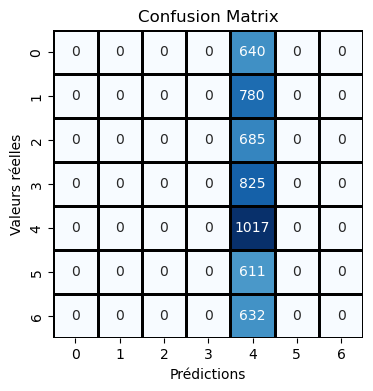

LogisticRegression


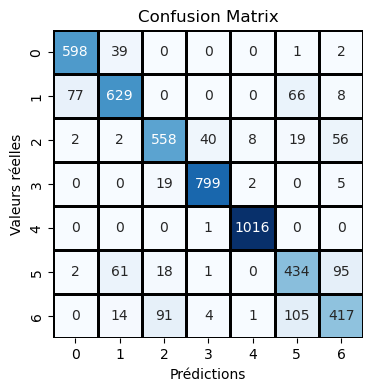

KNeighborsClassifier


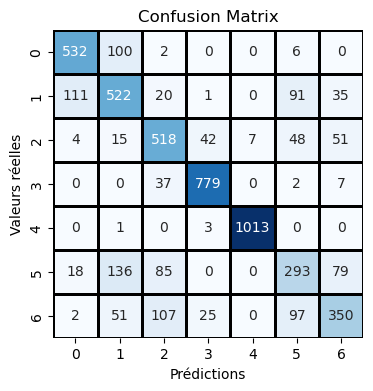

SGDClassifier


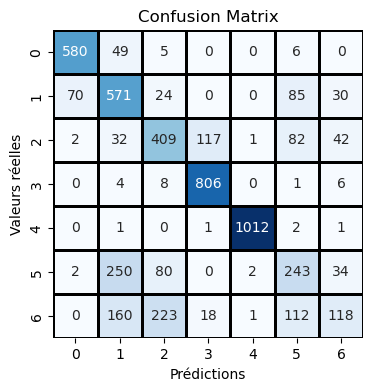

RandomForestClassifier


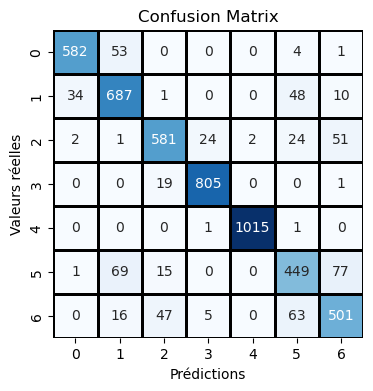

In [392]:
for i in df_prediction:
    print(i)
    matrice(df_prediction[i])
    

## ROC

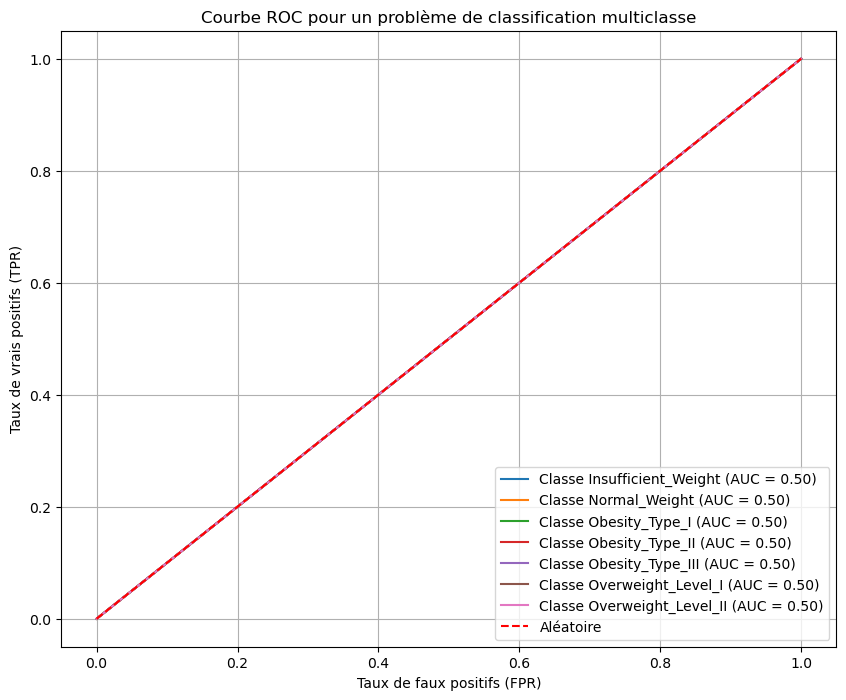

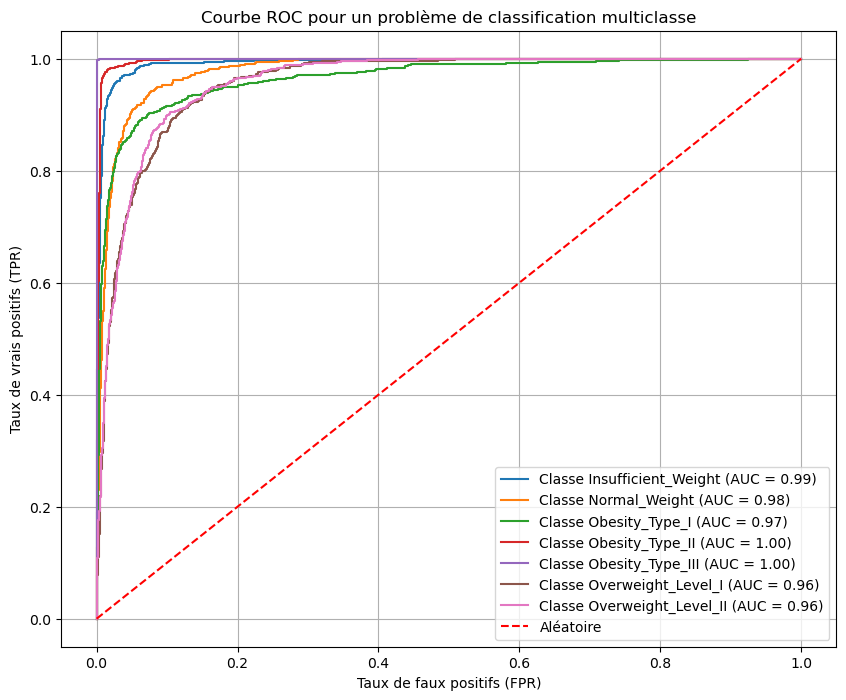

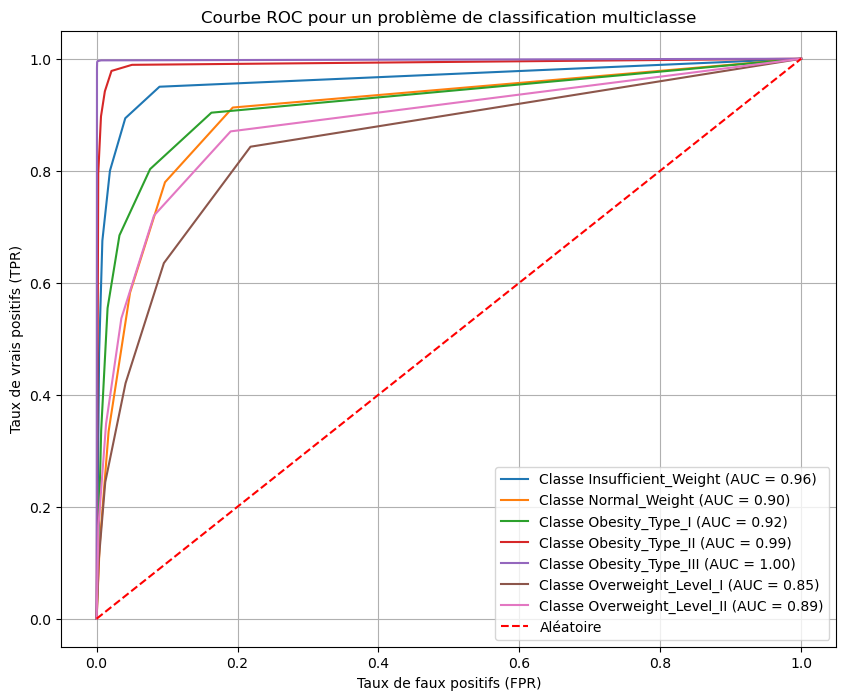

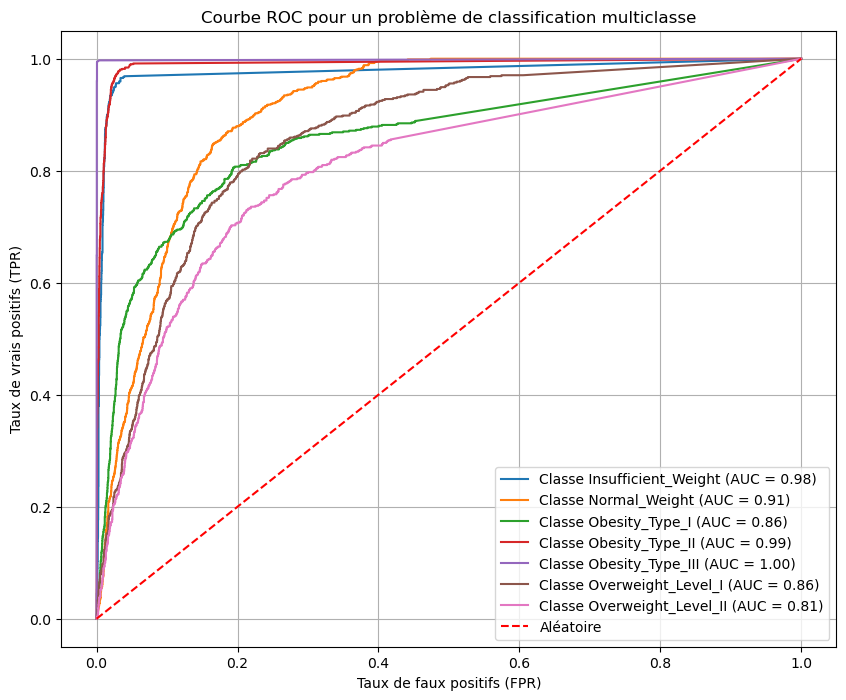

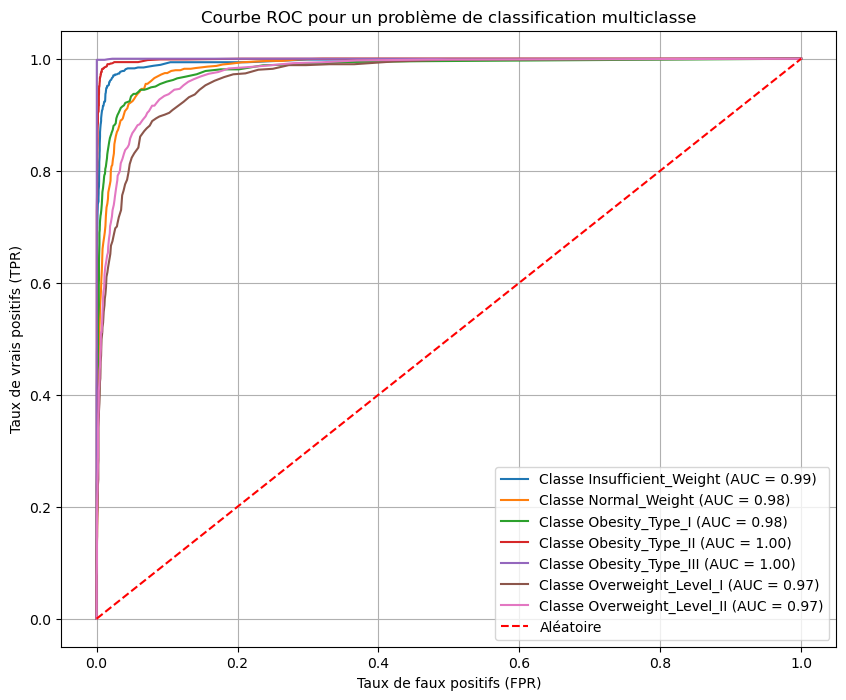

In [374]:
for i in dict_model_trained:
    ROC(dict_model_trained[i] )